In [1]:
from inference_api.visual_attention.manager import VAManager
from inference_api.visual_attention.log_manager import VALogDatabaseManager

/opt/conda/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the small

In [2]:
log_manager = VALogDatabaseManager('visual_attention')
va_manager = VAManager(log_manager)

INFO:allennlp.modules.elmo:Initializing ELMo


elmo embedder initialized on gpu?: False


INFO:root:2022-08-17 14:06:50.909186 - Begin Batch 1 out of 1 


('flickr/1027149103.jpg', 'flickr/101362650.jpg', 'flickr/1026792563.jpg', 'flickr/1000919630.jpg', 'flickr/1021293940.jpg', 'flickr/1012150929.jpg', 'flickr/1029450589.jpg', 'flickr/102351840.jpg', 'flickr/102860573.jpg')
['A band is playing in front of an audience and the singer is wearing an orange shirt and has tattoos on his arm.', 'Two people are demonstrating martial arts to a crowd and jumping over three youngsters who are crouched on the mat.', 'A group of woman and children are standing or sitting in front of rows of vegetables.', 'A man sits in a chair while holding a large stuffed animal of a lion.', 'Two men are hiking in a forest where snow is partially covering the ground.', "A little boy plays with a Nintendo GameCube controller inside a McDonald 's.", 'An adult wearing a gray shirt with red sleeves sleeping on a couch.', 'A man is drilling through the frozen ice of a pond.', 'A construction site on a street with three men working.']


/src/evaluation/word_attention_generator.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 5, )


{}

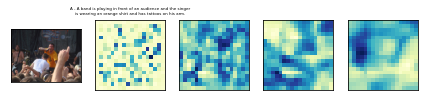

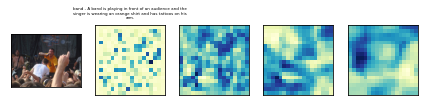

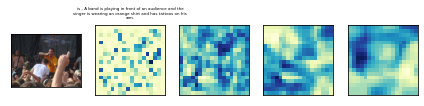

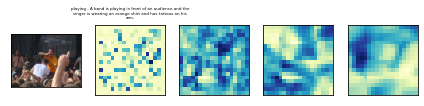

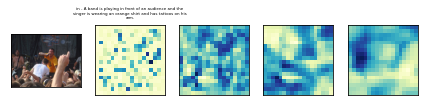

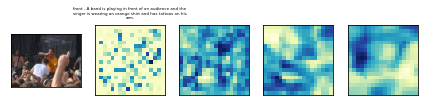

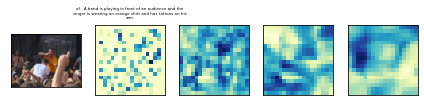

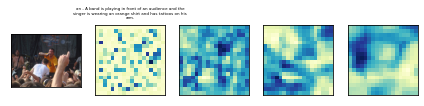

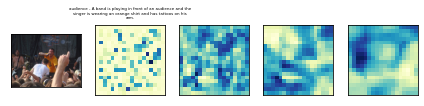

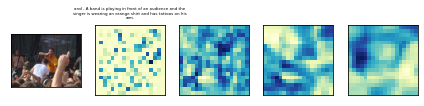

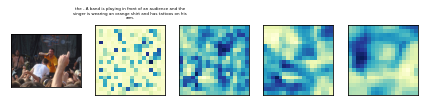

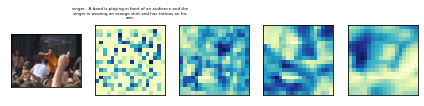

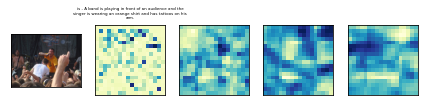

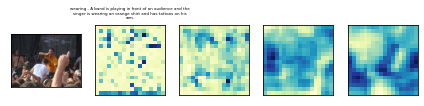

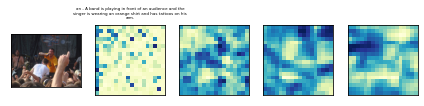

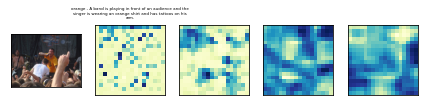

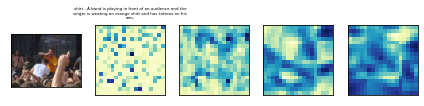

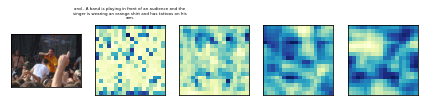

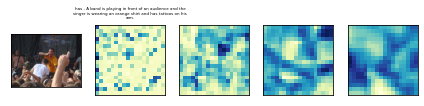

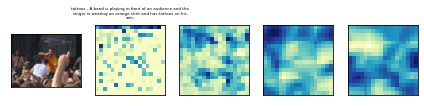

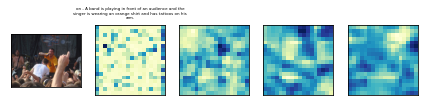

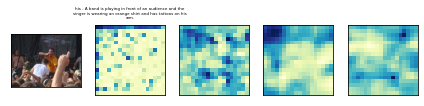

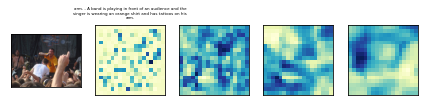

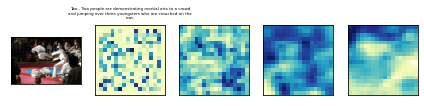

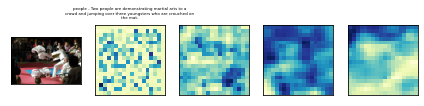

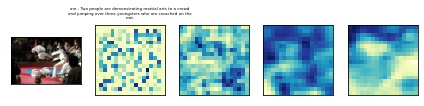

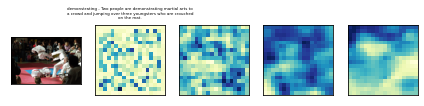

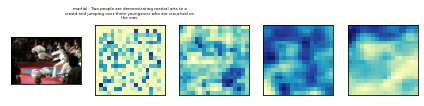

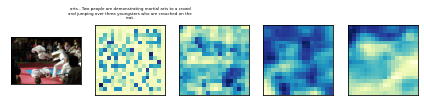

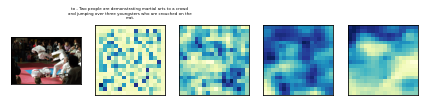

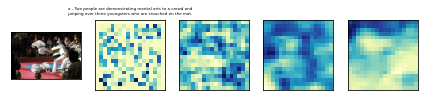

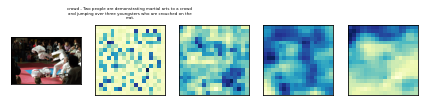

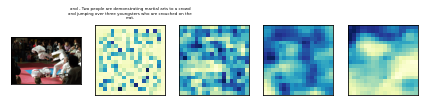

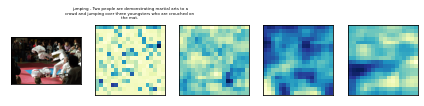

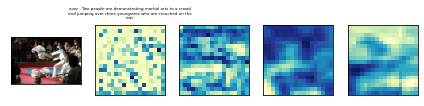

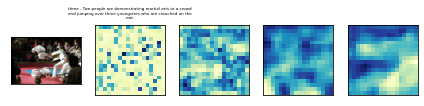

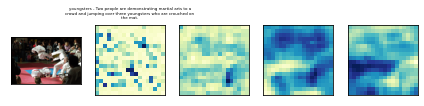

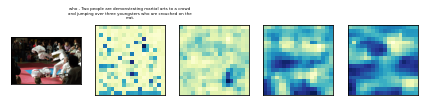

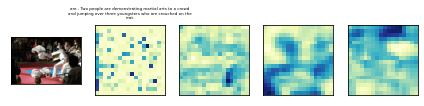

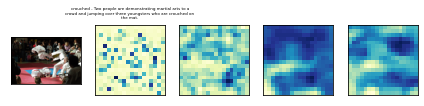

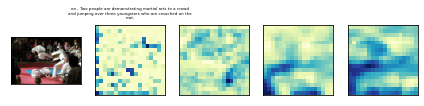

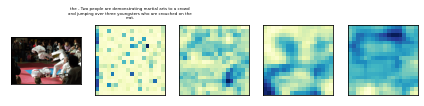

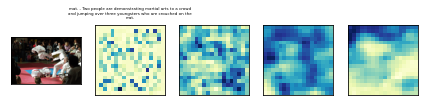

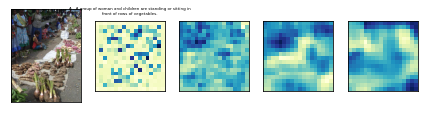

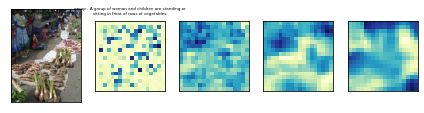

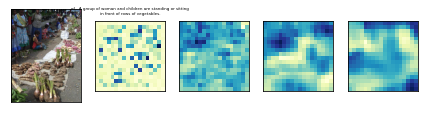

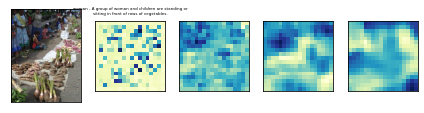

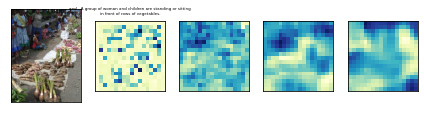

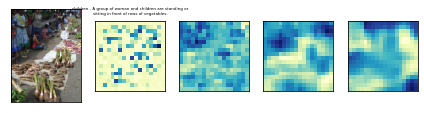

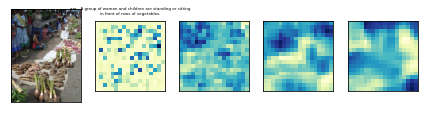

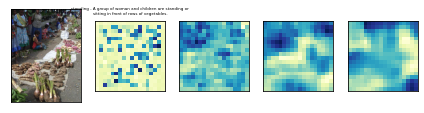

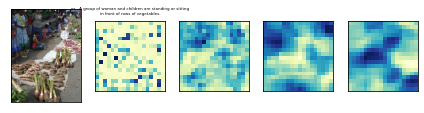

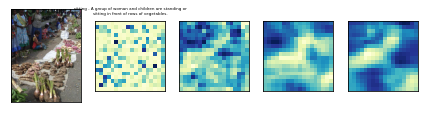

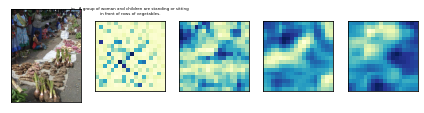

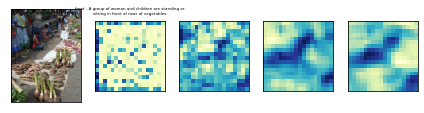

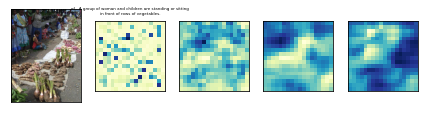

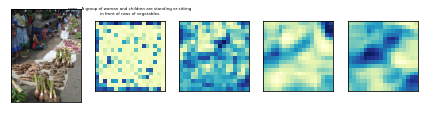

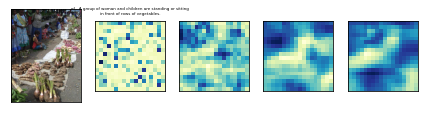

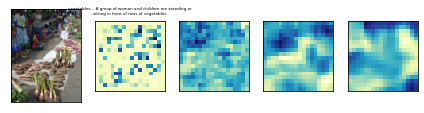

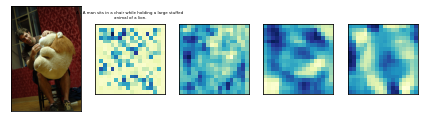

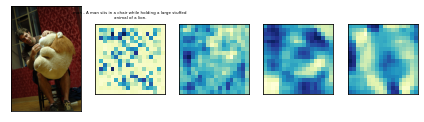

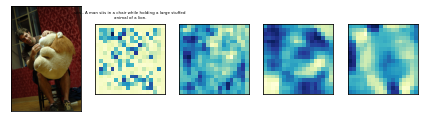

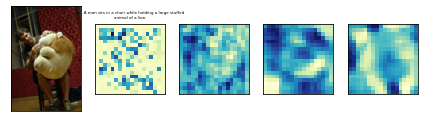

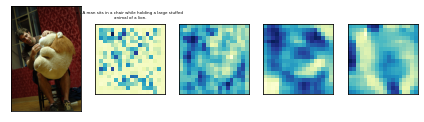

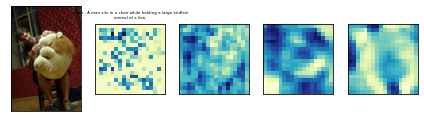

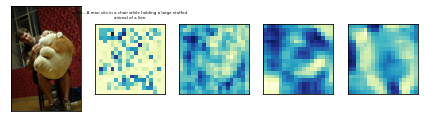

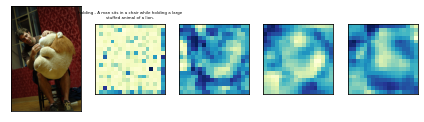

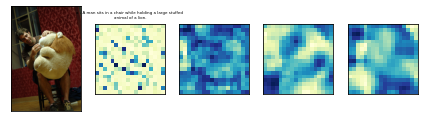

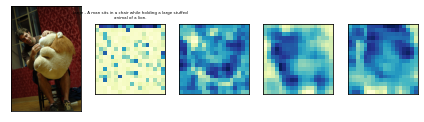

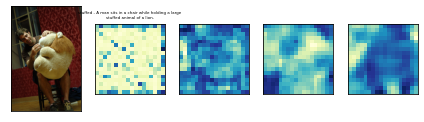

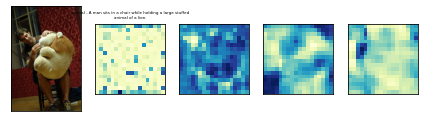

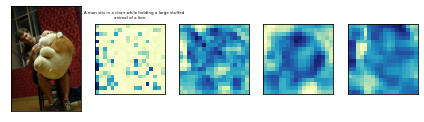

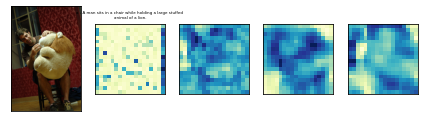

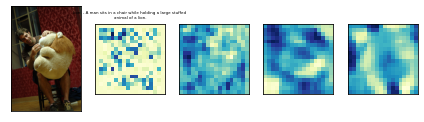

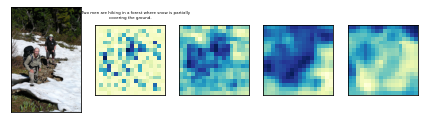

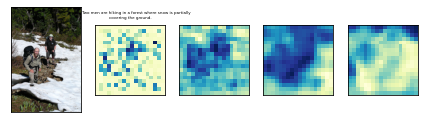

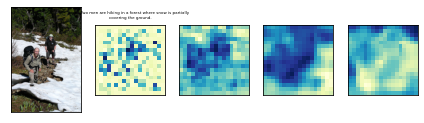

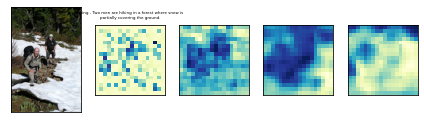

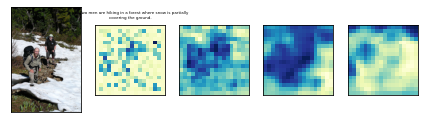

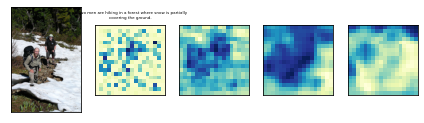

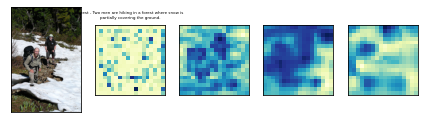

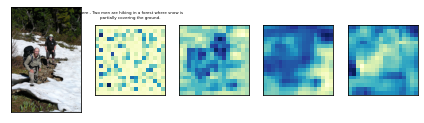

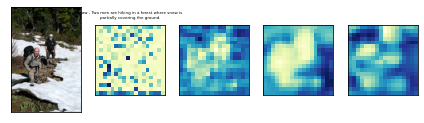

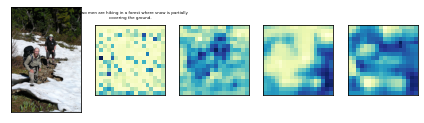

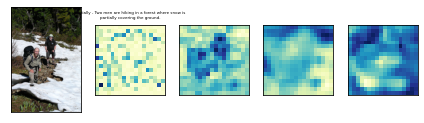

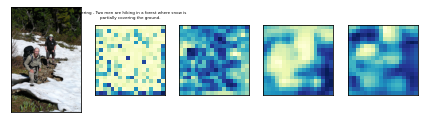

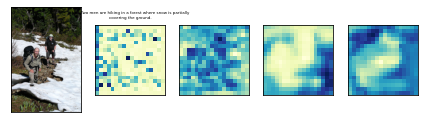

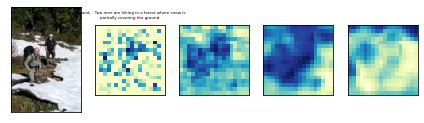

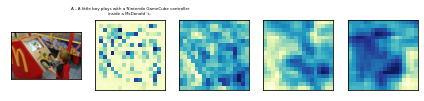

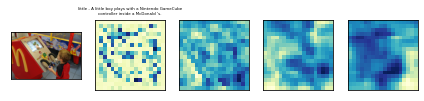

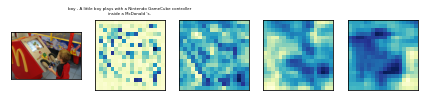

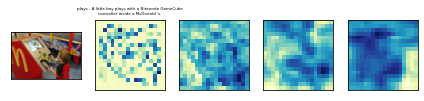

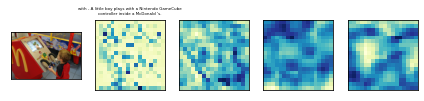

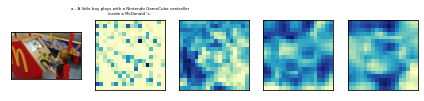

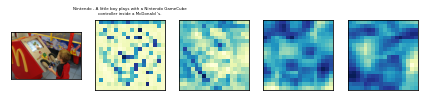

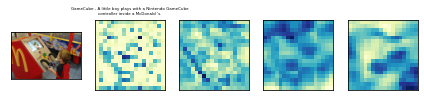

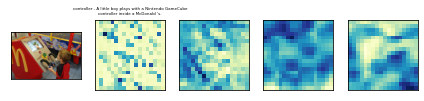

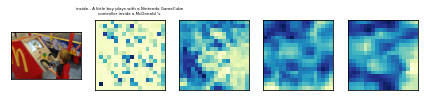

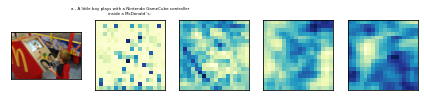

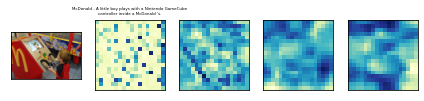

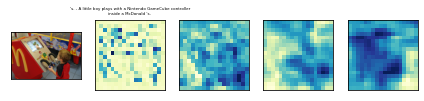

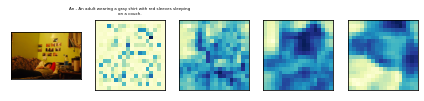

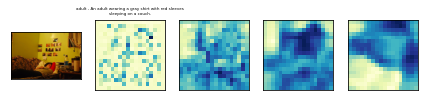

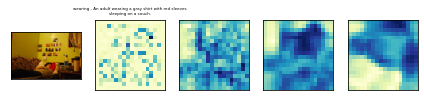

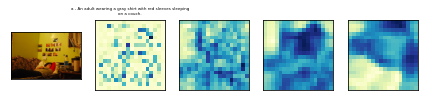

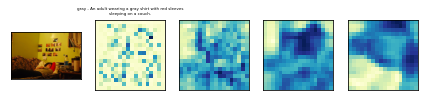

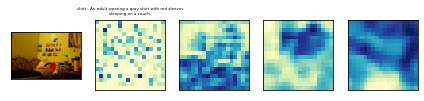

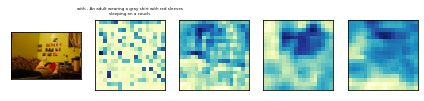

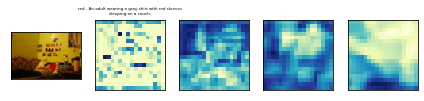

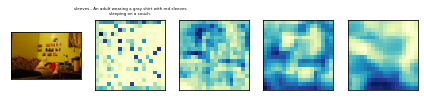

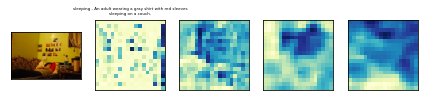

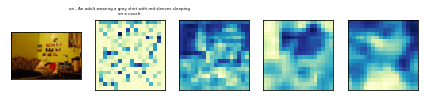

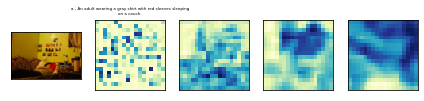

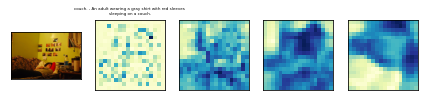

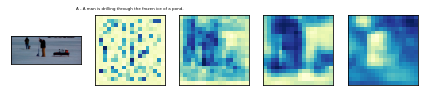

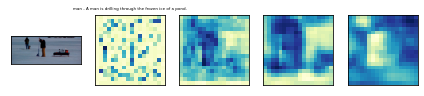

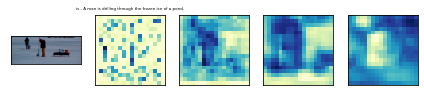

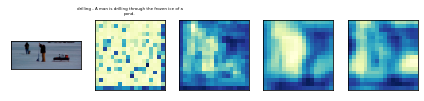

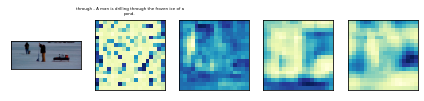

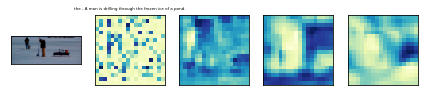

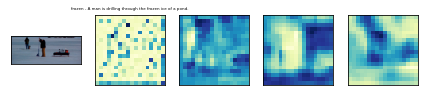

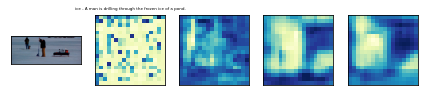

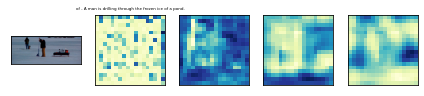

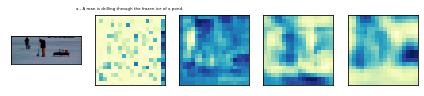

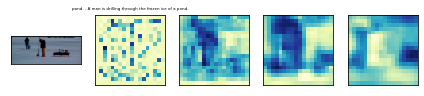

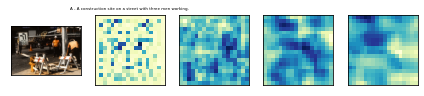

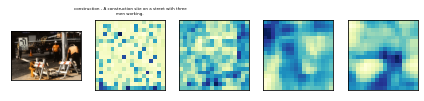

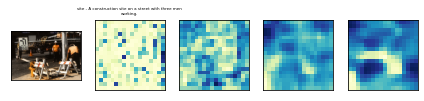

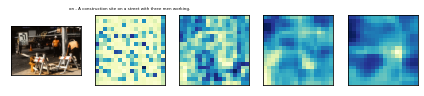

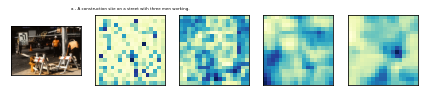

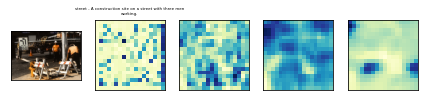

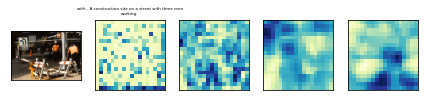

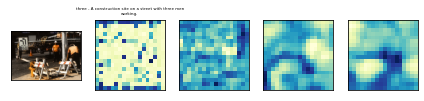

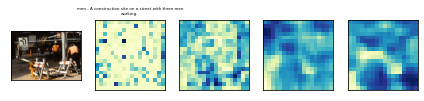

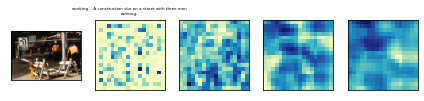

In [3]:
va_manager.infer([0,1,2,3,4,5,6,7,8])

In [ ]:
from pytorch_lightning.utilities.deepspeed import (convert_zero_checkpoint_to_fp32_state_dict)
convert_zero_checkpoint_to_fp32_state_dict('/models/flickr_trained/best.ckpt', '/models/flickr_trained/model.ckpt',tag=None)

In [ ]:
dict_one = {'name': 'John', 'last_name': 'Doe', 'job': 'Python Consultant'}
dict_two = {'name': 'Jane', 'last_name': 'Doe', 'job': 'Community Manager'}
batch = [dict_one.items(),dict_two.items()]

for a in zip(*batch):
    print(a)